In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import matplotlib.pyplot as plt
import os
from datetime import datetime
import random
import string
import ray
ray.init();

2019-03-20 21:18:26,411	WARNING worker.py:1381 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2019-03-20 21:18:26,417	INFO node.py:439 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-03-20_21-18-26_4444/logs.
2019-03-20 21:18:26,541	INFO services.py:364 -- Waiting for redis server at 127.0.0.1:44580 to respond...
2019-03-20 21:18:26,697	INFO services.py:364 -- Waiting for redis server at 127.0.0.1:14295 to respond...
2019-03-20 21:18:26,700	INFO services.py:761 -- Starting Redis shard with 10.0 GB max memory.
2019-03-20 21:18:26,753	WARNING services.py:1301 -- Warning: Capping object memory store to 20.0GB. To increase this further, specify `object_store_memory` when calling ray.init() or ray start.
2019-03-20 21:18:26,755	INFO services.py:1449 -- Starting the Plasma object store with 20.0 GB memory using /dev/shm.


In [2]:
seed = 161
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
# os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
env.seed(seed);

N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [3]:
C_POS_MAX =  5
C_POS_MIN = -5

C_VEL_MAX =  5
C_VEL_MIN = -5

P_ANG_MAX =  1
P_ANG_MIN = -1

P_VEL_MAX =  5
P_VEL_MIN = -5

In [4]:
GRANULARITY = 100
print("GRANULARITY: ", GRANULARITY)

GRANULARITY:  100


In [5]:
Q_TABLE = np.zeros((GRANULARITY,
                    GRANULARITY,
                    GRANULARITY,
                    GRANULARITY, 
                    N_ACTIONS))

c_pos_s = np.linspace(C_POS_MIN, C_POS_MAX, GRANULARITY)
c_vel_s = np.linspace(C_VEL_MIN, C_VEL_MAX, GRANULARITY)
p_ang_s = np.linspace(P_ANG_MIN, P_ANG_MAX, GRANULARITY)
p_vel_s = np.linspace(P_VEL_MIN, P_VEL_MAX, GRANULARITY)

In [6]:
def discretize(c_pos_val, c_vel_val, p_ang_val, p_vel_val, c_pos_s, c_vel_s, p_ang_s, p_vel_s):
    c_pos_indx = np.where(c_pos_s >= c_pos_val)[0][0].astype(int)
    c_vel_indx = np.where(c_vel_s >= c_vel_val)[0][0].astype(int)
    p_ang_indx = np.where(p_ang_s >= p_ang_val)[0][0].astype(int)
    p_vel_indx = np.where(p_vel_s >= p_vel_val)[0][0].astype(int)
    return [c_pos_indx, c_vel_indx, p_ang_indx, p_vel_indx]

In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
T_LR           = 1e-1
T_GAMMA        = 0.9
T_EPSILON      = 0.95

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [9]:
# Hyper Parameters
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
TERMINAL_BIAS       = 0.8   # no. of terminal memories in batch
MIN_MEMORY_CAP      = 20000

In [10]:
MAX_NO_OF_ITERATIONS = 10
NN_ITERATIONS    = 20000

In [11]:
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(N_STATES, 50)
        nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
        self.out = nn.Linear(50, N_ACTIONS)
        nn.init.xavier_uniform_(self.out.weight)   # initialization

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        actions_value = self.out(x)
        return actions_value
    
class DQN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()
#         print("Neural net")
#         print(self.eval_net)

        self.learn_step_counter  = 0 # for target updating
        
        self.good_memory_counter = 0 # for storing non-terminal memories
        self.good_memory         = np.zeros(N_STATES*2+2)#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.bad_memory_counter  = 0 # for storing terminal memories
        self.bad_memory          = np.zeros(N_STATES*2+2)#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy()
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        good_sample_index = np.random.choice(int(self.good_memory.shape[0]), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
        bad_sample_index  = np.random.choice(int(self.bad_memory.shape[0]),  int(BATCH_SIZE*TERMINAL_BIAS))

        b_good_memory = self.good_memory[good_sample_index, :]
        b_bad_memory  = self.bad_memory[bad_sample_index, :]
        b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [12]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [13]:
dqn = DQN()

In [14]:
RFILE = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8))+"combo"+str(GRANULARITY)
print("SCRATCH FILE = ", RFILE)

SCRATCH FILE =  STI6WR1Zcombo100


In [15]:
@ray.remote
def node_run(Q_TABLE):
    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195
    
    PERFECT_RUN  = 10
    exp_rec      = np.empty(N_STATES * 2 + 2)
    my_EPSILON   = T_EPSILON
    my_LR        = T_LR
    my_Q_TABLE   = Q_TABLE.copy()
    
    for i_episode in range(NO_OF_EPISODES):
        ep_exp_rec = np.empty(N_STATES * 2 + 2)
        time_steps = 0
        
        s = env.reset()
        while True:
            [c_pos_state, 
            c_vel_state, 
            p_ang_state, 
            p_vel_state] = discretize(s[0],s[1],s[2],s[3],
                                     c_pos_s, 
                                     c_vel_s, 
                                     p_ang_s, 
                                     p_vel_s)
            time_steps += 1
            if np.random.uniform() > my_EPSILON:   # greedy
                a = np.random.randint(0, N_ACTIONS)
            else:
                a = Q_TABLE[c_pos_state, c_vel_state, p_ang_state, p_vel_state, :].argmax()

             # take action
            s_, r, done, info = env.step(a)

            if done:
                r = -1
                if time_steps >= TIMESTEP_LIMIT:
                    r = 1

            experience = np.hstack((s,a,r,s_))
            exp_rec = np.vstack((exp_rec, experience))

            #discretize next_state
            [next_c_pos_state, 
            next_c_vel_state, 
            next_p_ang_state, 
            next_p_vel_state] = discretize(s_[0],    s_[1],    s_[2],    s_[3],
                                          c_pos_s,  c_vel_s,  p_ang_s,  p_vel_s)

            # learn
            this_state = tuple([c_pos_state, 
                          c_vel_state, 
                          p_ang_state, 
                          p_vel_state])

            next_state = tuple([ next_c_pos_state, 
                           next_c_vel_state, 
                           next_p_ang_state, 
                           next_p_vel_state])

            my_Q_TABLE[this_state][a] = my_Q_TABLE[this_state][a] + my_LR * (r + T_GAMMA * my_Q_TABLE[next_state].max() - 
                                                                     my_Q_TABLE[this_state][a])
            if done:
                time_rec[i_episode] = time_steps
                break
            s = s_
        
        #TO LEVEL UP    
        if np.mean(time_rec[-10:]) > level_up_metric:
            PERFECT_RUN_COUNTER += 1
        else:
            PERFECT_RUN_COUNTER = 0

        if PERFECT_RUN_COUNTER > PERFECT_RUNS_HIGH_SCORE:
            PERFECT_RUN_COUNTER = 0
            PERFECT_RUNS_HIGH_SCORE *= 1.5
            my_LR *= 0.2
            if my_EPSILON < 0.99:
                my_EPSILON += 0.02
    exp_rec = np.delete(exp_rec, 0, 0)
    return exp_rec, time_rec

In [16]:
@ray.remote
def node_run_TEST(Q_TABLE):
    # no learning
    # only greedy actions
    time_rec                = np.zeros(NO_OF_EPISODES)
#     level_up_flag           = False
#     PERFECT_RUN_COUNTER     = 10
#     PERFECT_RUNS_HIGH_SCORE = 10
#     level_up_metric         = 195
    
#     PERFECT_RUN  = 10
#     exp_rec      = np.empty(N_STATES * 2 + 2)
    my_EPSILON   = 1
#     my_LR        = T_LR
    my_Q_TABLE   = Q_TABLE.copy()
    
    for i_episode in range(NO_OF_EPISODES):
#         ep_exp_rec = np.empty(N_STATES * 2 + 2)
        time_steps = 0
        
        s = env.reset()
        while True:
            [c_pos_state, 
            c_vel_state, 
            p_ang_state, 
            p_vel_state] = discretize(s[0],s[1],s[2],s[3],
                                     c_pos_s, 
                                     c_vel_s, 
                                     p_ang_s, 
                                     p_vel_s)
            time_steps += 1
            if np.random.uniform() > my_EPSILON:   # greedy
                a = np.random.randint(0, N_ACTIONS)
            else:
                a = Q_TABLE[c_pos_state, c_vel_state, p_ang_state, p_vel_state, :].argmax()

             # take action
            s_, r, done, info = env.step(a)

            if done:
                r = -1
                if time_steps >= TIMESTEP_LIMIT:
                    r = 1

#             experience = np.hstack((s,a,r,s_))
#             exp_rec = np.vstack((exp_rec, experience))

            #discretize next_state
            [next_c_pos_state, 
            next_c_vel_state, 
            next_p_ang_state, 
            next_p_vel_state] = discretize(s_[0],    s_[1],    s_[2],    s_[3],
                                          c_pos_s,  c_vel_s,  p_ang_s,  p_vel_s)

#             # learn
#             this_state = tuple([c_pos_state, 
#                           c_vel_state, 
#                           p_ang_state, 
#                           p_vel_state])

#             next_state = tuple([ next_c_pos_state, 
#                            next_c_vel_state, 
#                            next_p_ang_state, 
#                            next_p_vel_state])

#             my_Q_TABLE[this_state][a] = my_Q_TABLE[this_state][a] + my_LR * (r + T_GAMMA * my_Q_TABLE[next_state].max() - 
#                                                                      my_Q_TABLE[this_state][a])
            if done:
                time_rec[i_episode] = time_steps
                break
            s = s_
        
#         #TO LEVEL UP    
#         if np.mean(time_rec[-10:]) > level_up_metric:
#             PERFECT_RUN_COUNTER += 1
#         else:
#             PERFECT_RUN_COUNTER = 0

#         if PERFECT_RUN_COUNTER > PERFECT_RUNS_HIGH_SCORE:
#             PERFECT_RUN_COUNTER = 0
#             PERFECT_RUNS_HIGH_SCORE *= 1.5
#             my_LR *= 0.2
#             if my_EPSILON < 0.99:
#                 my_EPSILON += 0.02
#     exp_rec = np.delete(exp_rec, 0, 0)
    return time_rec



ITERATION # 0
TABULAR EPSILON =  0.95
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 0: 14
REAL TIME TO GENERATE 9594.000000 EXPERIENCES:0:00:05.328409


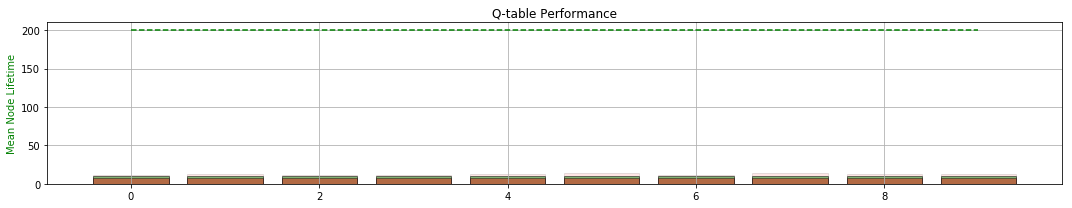

Training Neural Network for 20000 iterations @ LR =  0.001
25 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating	MEAN TIME:  9.41
Validating	MEAN TIME:  9.465
Validating	MEAN TIME:  9.36
Validating	MEAN TIME:  74.055
Validating	MEAN TIME:  99.055
TRAINING TIME:0:00:27.069375


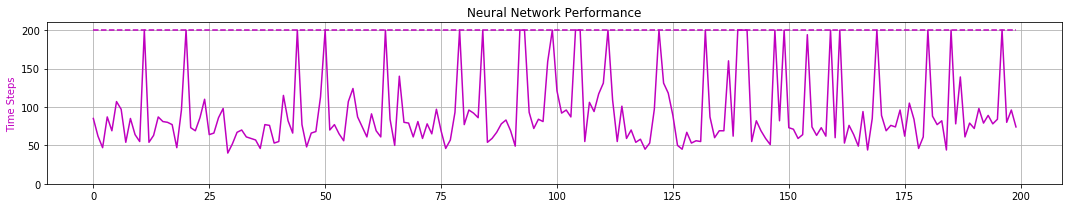

DISCRETIZING THE Q-TABLE...
CPU times: user 41.6 s, sys: 18.5 s, total: 1min
Wall time: 21.5 s
DISCRETIZING FINISHED


ITERATION # 1
TABULAR EPSILON =  0.95
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 1: 200
REAL TIME TO GENERATE 64209.000000 EXPERIENCES:0:00:03.140078


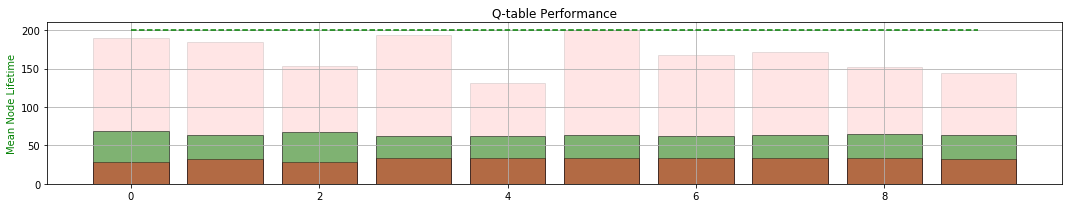

Training Neural Network for 20000 iterations @ LR =  0.001
25 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating	MEAN TIME:  200.0
Validating	MEAN TIME:  200.0
Validating	MEAN TIME:  160.485
Validating	MEAN TIME:  196.615
Validating	MEAN TIME:  143.535
TRAINING TIME:0:00:42.901750


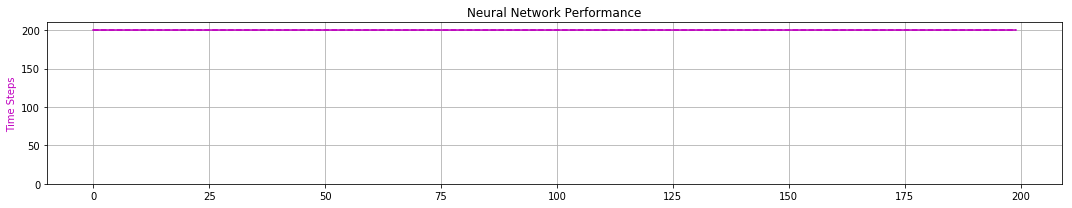

DISCRETIZING THE Q-TABLE...
CPU times: user 41.9 s, sys: 17.9 s, total: 59.9 s
Wall time: 20.7 s
DISCRETIZING FINISHED


ITERATION # 2
TABULAR EPSILON =  0.95
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 2: 200
REAL TIME TO GENERATE 200000.000000 EXPERIENCES:0:00:13.359643


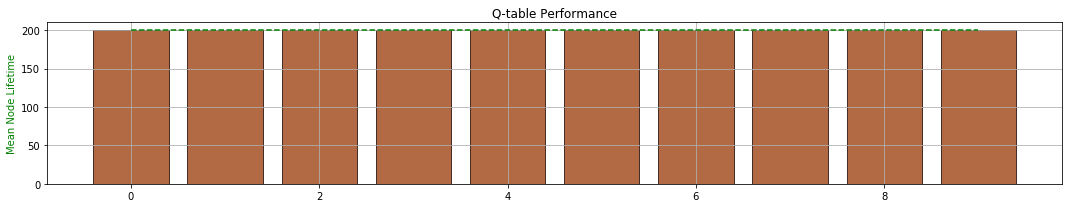

Problem SOLVED after ITERATION#:  2


In [17]:
iteration = 0
while iteration < MAX_NO_OF_ITERATIONS:
    print("\n")
    print("ITERATION #", iteration)
    print("TABULAR EPSILON = ", T_EPSILON)
    print("TABULAR LR      = ", T_LR)

    tic = datetime.now()
    result = ray.get([node_run.remote(Q_TABLE) for i in range(NO_OF_NODES)])
    node_time_rec = np.array([item[1] for item in result ])
    node_exp = np.array([item[0] for item in result ])
    all_exp = np.array([item for each_node_exp in node_exp 
                                for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,10)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    print("LARGEST TIMESTEP in ITERATION {:d}: {:d}".format(iteration, node_time_rec.max().astype(int)))
    print("REAL TIME TO GENERATE {:f} EXPERIENCES:{}".format(node_time_rec.sum(), (datetime.now()-tic)))
    #PLOT EXPERIENCES
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    if node_min_time.min() > 195:
        print("Problem SOLVED after ITERATION#: ",iteration)
        break
    
    #shuffle experiences
    np.random.shuffle(all_exp)

    #segregate experiences
    good_mem = all_exp[all_exp[:,5] == 1]
    bad_mem  = all_exp[all_exp[:,5]  < 1]
     
    if good_mem.shape[0] < BATCH_SIZE:
        dqn.good_memory = np.vstack((dqn.good_memory, good_mem))
    else:
        dqn.good_memory = good_mem
        
    if bad_mem.shape[0] < BATCH_SIZE:
        dqn.bad_memory = np.vstack((dqn.bad_memory, bad_mem))
    else:
        dqn.bad_memory = bad_mem

    #learn
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    print(int(BATCH_SIZE*TERMINAL_BIAS),"TERMINAL EXPERIENCES IN A BATCH SIZE OF",BATCH_SIZE)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("Validating", end='\t')
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = env.reset()
                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = env.step(a)
                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                torch.save(dqn.eval_net.state_dict(), RFILE +'_'+str(GRANULARITY))

    print("TRAINING TIME:{}".format(datetime.now()-tic))

    best_dqn = DQN()
    best_dqn.eval_net.load_state_dict(torch.load(RFILE +'_'+str(GRANULARITY)))
    best_dqn.eval_net.eval()

    #test NN policy
    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()
        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    # Use the best model to create Q-table but allow the original model to continue learning from where it left off
    print("DISCRETIZING THE Q-TABLE...")
    state_combinations = ndim_grid([C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN],
                                   [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX],
                                       GRANULARITY)
    %time Q_TABLE = best_dqn.get_qvals(state_combinations).reshape(GRANULARITY,GRANULARITY,GRANULARITY,GRANULARITY,-1)
    print("DISCRETIZING FINISHED")
    
    iteration+=1


In [18]:
print("TOTAL SERIAL TIMESTEPS   : ", total_serial_timesteps)
print("TOTAL PARALLEL TIMESTEPS : ", total_parallel_timesteps)
print("SPEED UP PERCENTAGE      : ", total_serial_timesteps/total_parallel_timesteps)

TOTAL SERIAL TIMESTEPS   :  273803.0
TOTAL PARALLEL TIMESTEPS :  414.0
SPEED UP PERCENTAGE      :  661.3599033816425


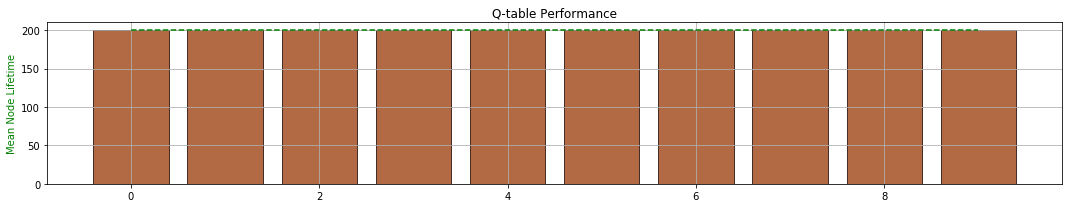

In [19]:
result = ray.get([node_run_TEST.remote(Q_TABLE) for i in range(NO_OF_NODES)])
node_time_rec = np.array([item for item in result ])

# total_parallel_timesteps += node_time_rec.max()
# total_serial_timesteps   += node_time_rec.sum()
# print("LARGEST TIMESTEP in ITERATION {:d}: {:f}".format(iteration, node_time_rec.max()))
# print("REAL TIME TO GENERATE {:f} EXPERIENCES:{}".format(node_time_rec.sum(), (datetime.now()-tic)))
#PLOT EXPERIENCES
node_avg_time = node_time_rec.mean(axis=1)
node_std_time = node_time_rec.std(axis=1)
node_max_time = node_time_rec.max(axis=1)
node_min_time = node_time_rec.min(axis=1)

fig = plt.figure(figsize = (15,3))
ax2 = fig.add_subplot(1, 1, 1)
ax2.set_title("Q-table Performance")
ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
ax2.set_ylabel('Mean Node Lifetime',color = 'g')
ax2.set_ylim(0,TIMESTEP_LIMIT+10)
fig.tight_layout()
ax2.grid()
plt.show()